# 1 Pip installs and imports:

In [1]:
# Pip Installs
!pip install contractions
!pip install --upgrade tensorflow
!pip install keras-tuner
!pip install emoji

In [1]:
# Imports
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc
import contractions
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import keras_tuner as kt
from keras_tuner import Hyperband, HyperModel
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import re
import emoji
import seaborn as sns
import pydot

[nltk_data] Downloading package punkt to /Users/liqing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/liqing/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/liqing/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liqing/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ModuleNotFoundError: No module named 'contractions'

# 2 Data Processing

In [3]:
# Function to convert emojis to words
def convert_emojis(text):
    return emoji.demojize(text, delimiters=("", ""))

# Function to reduce repetitive characters
def reduce_repetitions(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

# Function to clean tweets
def clean_tweet(tweet):
    # Transform emojis to words
    tweet = convert_emojis(tweet)
    # Convert to lowercase
    tweet = tweet.lower()
    # Reduce repetitive characters
    tweet = reduce_repetitions(tweet)
    # Remove Numbers
    tweet = re.sub(r'\d+', '', tweet)
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove HTML tags
    tweet = re.sub(r'<[^>]+>', '', tweet)
    # Remove double spaces
    tweet = re.sub(r'\s+', ' ', tweet)
    # Remove "@" mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove special characters
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    # Expand contractions
    tweet = contractions.fix(tweet)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tweet = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(tweet)])
    return tweet


# Read the file
df = pd.read_csv('Sentiment140.tenPercent.sample.tweets.tsv', low_memory=False, sep='\t')

# Apply cleaning function to tweets
df['tweet_text'] = df['tweet_text'].apply(clean_tweet)

print(df['tweet_text'].head())

0    hey dear happy friday to you already had your ...
1    ughh layin downn waiting for zeina to cook bre...
2    i reckon hell play even if he not but i know n...
3                            i know saw it on the news
4    very sad that ha closed down one of the few we...
Name: tweet_text, dtype: object


# 3 Logistic Regression

Logistic Regression Test Accuracy: 0.78171875
Logistic Regression Training Accuracy: 0.7980703125

Classification report for predicting test data:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78     16002
           4       0.77      0.80      0.78     15998

    accuracy                           0.78     32000
   macro avg       0.78      0.78      0.78     32000
weighted avg       0.78      0.78      0.78     32000



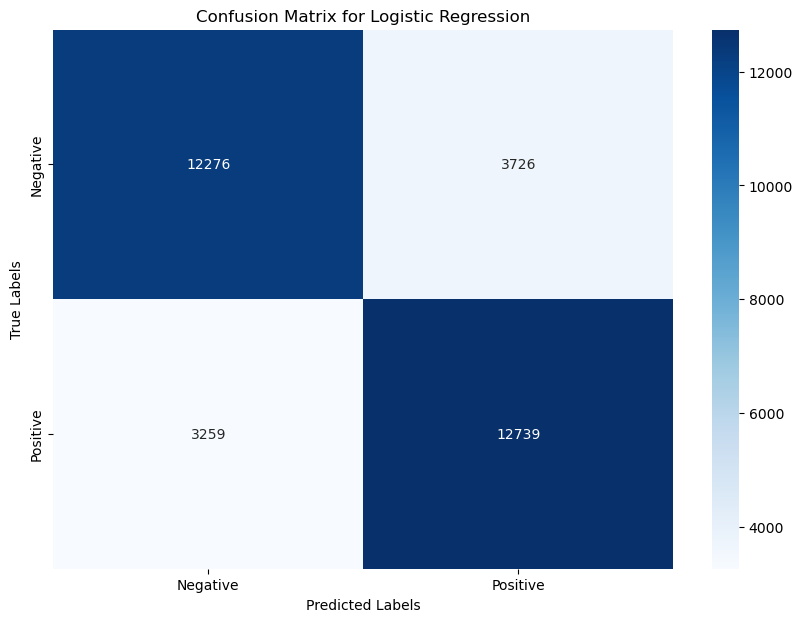

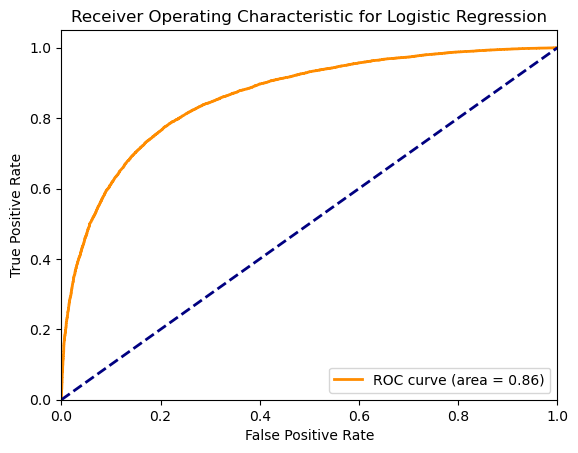

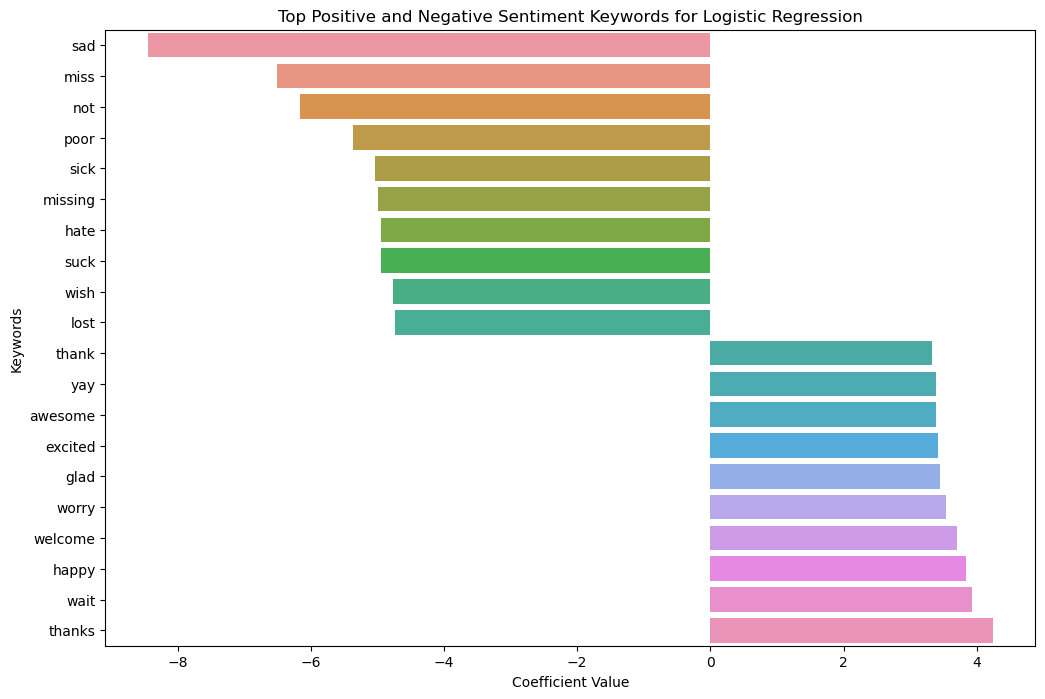

In [4]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['tweet_text'], df['sentiment_label'], 
                                                    test_size=0.2, random_state=42)


# Vectorizing text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=6000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Training Logistic Regression model
lr_model = LogisticRegression(max_iter=10000, C=0.5455594781168515, 
                              class_weight='balanced', solver='saga')

lr_model.fit(X_train_tfidf, y_train)

# Predicting on the test data and ecaluating accuracy
y_test_pred = lr_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Logistic Regression Test Accuracy:", test_accuracy)

# Predicting on the training data and evaluating accuracy
y_train_pred = lr_model.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Logistic Regression Training Accuracy:", train_accuracy)

# Classification Report
print('\nClassification report for predicting test data:\n' + classification_report(y_test, y_test_pred))

# Setting Class labels
class_labels = ['Negative', 'Positive']

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# ROC Curve
pos_label = 4
y_test_proba = lr_model.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba, pos_label=pos_label)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

# Plotting the most impactful keywords
# Extracting the feature names (words) from the TF-IDF Vectorizer
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Extracting the coefficients of the Logistic Regression model
coefficients = lr_model.coef_[0]

# Getting the indices of the 10 most positive and 10 most negative coefficients
top_positive_coefficients = np.argsort(coefficients)[-10:]
top_negative_coefficients = np.argsort(coefficients)[:10]

# Combine top positive and negative coefficients and their names
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
top_coefficients_names = feature_names[top_coefficients]
top_coefficients_values = coefficients[top_coefficients]

# Create a DataFrame for plotting
data_for_plot = pd.DataFrame({
    'Features': top_coefficients_names,
    'Coefficients': top_coefficients_values
})

# Sort the DataFrame by coefficients for better visualization
data_for_plot = data_for_plot.sort_values(by='Coefficients')

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficients', y='Features', data=data_for_plot)
plt.title('Top Positive and Negative Sentiment Keywords for Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Keywords')
plt.show()

# 4 Recurrent Neural Network


Epoch 1/2


1000/1000 [==============================] - 410s 405ms/step - loss: 0.4900 - accuracy: 0.7630 - val_loss: 0.4462 - val_accuracy: 0.7925
Epoch 2/2
1000/1000 [==============================] - 22s 21ms/step - loss: 0.4425 - accuracy: 0.7983
Training Data Accuracy: 80.97%
Test Data Accuracy: 79.83%
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     16002
           1       0.80      0.80      0.80     15998

    accuracy                           0.80     32000
   macro avg       0.80      0.80      0.80     32000
weighted avg       0.80      0.80      0.80     32000



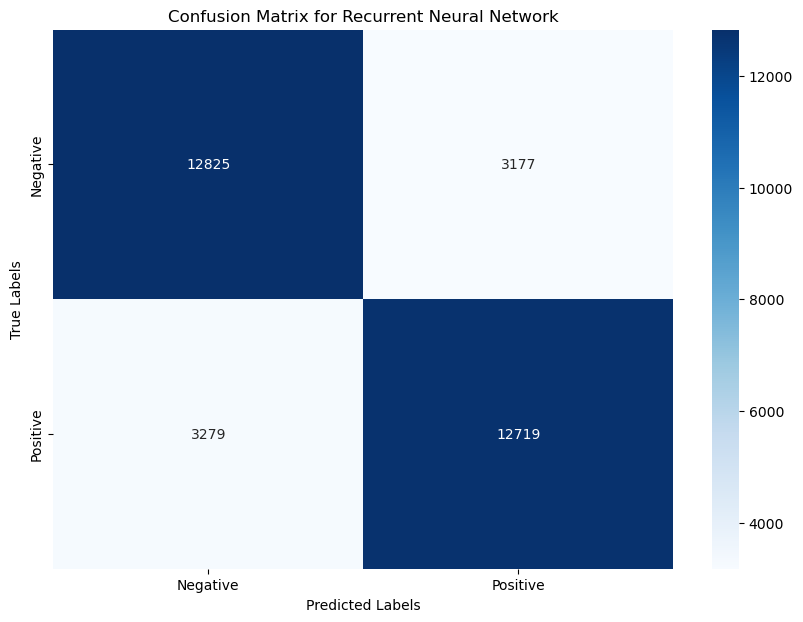

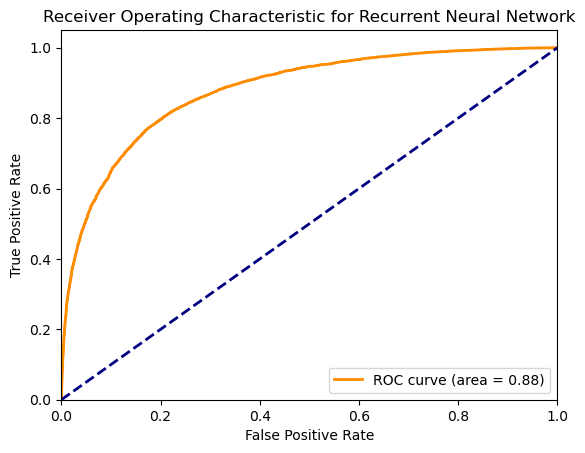

In [5]:
# Preparing text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['tweet_text'])
sequences = tokenizer.texts_to_sequences(df['tweet_text'])
data = pad_sequences(sequences, maxlen=100)

# Preparing labels
labels = pd.get_dummies(df['sentiment_label']).values

# Splitting the dataset
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(data, labels, test_size=0.2, random_state=42)

# Building the RNN model with optimized hyperparameters
rnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    LSTM(units=32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),  
    LSTM(units=64, dropout=0.3, recurrent_dropout=0.4, return_sequences=True),  
    LSTM(units=32, dropout=0.2, recurrent_dropout=0.2),  
    Dropout(0.2),  
    Dense(2, activation='softmax', kernel_regularizer=l2(0.00054728))  
])

# Compiling the model
optimizer = Adam(learning_rate=0.0015209)
rnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history = rnn_model.fit(X_train_rnn, y_train_rnn, batch_size=128, epochs=2,  
              validation_data=(X_test_rnn, y_test_rnn), callbacks=[early_stopping])

# Predictions
y_pred_rnn = rnn_model.predict(X_test_rnn)

# Convert predictions from one-hot encoded to class numbers for comparison
y_pred_rnn_classes = np.argmax(y_pred_rnn, axis=1)
y_true_rnn_classes = np.argmax(y_test_rnn, axis=1)

# Evaluate the model on the test data
test_loss, test_accuracy = rnn_model.evaluate(X_test_rnn, y_test_rnn)

# Extract the accuracy for the training data from the history object
train_accuracy = history.history['accuracy'][-1]  # Gets the last recorded training accuracy

# Print the accuracy for both the training and test data
print(f"Training Data Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Data Accuracy: {test_accuracy * 100:.2f}%")

# Classification report
print("Classification Report:")
report = classification_report(y_true_rnn_classes, y_pred_rnn_classes)
print(report)

# Confusion Matrix
class_labels = ['Negative', 'Positive']
cm_rnn = confusion_matrix(y_true_rnn_classes, y_pred_rnn_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm_rnn, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Recurrent Neural Network')
plt.show()

# ROC Curve
# Correcting classes
y_true_binary = np.where(y_true_rnn_classes == 4, 1, y_true_rnn_classes)  # Converts 4 to 1, keeps 0 as is

# Predicted probabilities for the positive class (class 1 in binary)
y_pred_proba = y_pred_rnn[:, 1]  

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Recurrent Neural Network')
plt.legend(loc="lower right")
plt.show()

# 5 Grid search optimization for Logistic Regression Hyperparameters + Reduction of overfitting, these results were used as hyperparameters in the Logistic regression above 

In [8]:
# TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Defining a C value range (narrowed down from previous grid searches)
C_values = np.logspace(-3, 1, 20)

param_grid = {
    'C': C_values,
    'class_weight': ['balanced'],
    'solver': ['saga']
}

# StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5)

# Setup the grid search with StratifiedKFold
grid_search = GridSearchCV(
    LogisticRegression(max_iter=50000, solver='saga'),
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Perform the grid search
grid_search.fit(X_train_tfidf, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the best model found by grid search
best_model = grid_search.best_estimator_

# Function to calculate the performance gap
def evaluate_performance_gap(model, X_train, y_train, X_test, y_test):
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    performance_gap = train_accuracy - test_accuracy
    return train_accuracy, test_accuracy, performance_gap

train_acc, test_acc, perf_gap = evaluate_performance_gap(best_model, X_train_tfidf, y_train, X_test_tfidf, y_test)

print(f"Training Accuracy: {train_acc}, Test Accuracy: {test_acc}, Performance Gap: {perf_gap}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'C': 0.8858667904100823, 'class_weight': 'balanced', 'solver': 'saga'}
Training Accuracy: 0.798859375, Test Accuracy: 0.7821875, Performance Gap: 0.016671875000000003


# 6 Grid search for finding optimal hyperparameters for Recurrent Neural Network + reduction of overfitting, these results were used as hyperparameters in the RNN above

In [7]:
# Hypermodel
class TweetSentimentHyperModel(HyperModel):
    def __init__(self, input_dim, max_length):
        self.input_dim = input_dim
        self.max_length = max_length
    
    def build(self, hp):
        model = Sequential()
        model.add(Embedding(input_dim=self.input_dim, output_dim=hp.Int('embedding_output_dim', 64, 128, step=32), input_length=self.max_length))
        
        for i in range(hp.Int('num_lstm_layers', 1, 3)):
            model.add(LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=96, step=32), return_sequences=i < hp.Int('num_lstm_layers', 1, 3) - 1,
                           dropout=hp.Float(f'lstm_dropout_{i}', 0.2, 0.5, step=0.1), recurrent_dropout=hp.Float(f'lstm_recurrent_dropout_{i}', 0.2, 0.5, step=0.1)))
        
        model.add(Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))
        model.add(Dense(2, activation='softmax', kernel_regularizer=l2(hp.Float('l2_regularization', 1e-4, 1e-2, sampling='log'))))
        
        model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

# Callback for logging
class HyperparametersLoggingCallback(Callback):
    def __init__(self, tuner):
        self.tuner = tuner

    def on_trial_end(self, trial_id, trial):
        hp = self.tuner.oracle.get_trial(trial_id).hyperparameters.values
        eval_result = self.tuner.oracle.get_trial(trial_id).score
        print(f"\nTrial complete: {trial_id}")
        print(f"Hyperparameters: {hp}")
        if eval_result:
            print(f"Validation Accuracy: {eval_result}\n")
        else:
            print("Evaluation result not available for this trial.\n")

# Set up the tuner
hypermodel = TweetSentimentHyperModel(input_dim=10000, max_length=100)
tuner = Hyperband(hypermodel, objective='val_accuracy', max_epochs=6, factor=3, directory='my_dir', project_name='tweet_sentiment')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Logging callback
logging_callback = HyperparametersLoggingCallback(tuner)

# Start the search
tuner.search(X_train_rnn, y_train_rnn, epochs=6, validation_data=(X_test_rnn, y_test_rnn), callbacks=[early_stopping, logging_callback])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
eval_result = best_model.evaluate(X_test_rnn, y_test_rnn)
print("[test loss, test accuracy]:", eval_result)


Reloading Tuner from my_dir\tweet_sentiment\tuner0.json

1000/1000 [==============================] - 30s 29ms/step - loss: 0.7744 - accuracy: 0.6023
[test loss, test accuracy]: [0.7744213342666626, 0.602343738079071]
